In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [11]:
import arviz as az
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(8)

In [73]:
def make_partial_normal_normal_model(samples, prior_wts_normal, prior_wts_other, n_normal):
    nobs, nsamp, ndim = samples.shape
    n_other = ndim - n_normal
    assert prior_wts_normal.shape == (nobs, nsamp), 'incorrect shape in prior_wts_normal'
    assert prior_wts_other.shape == (nobs, nsamp), 'incorrect shape in prior_wts_other'

    # Here we compute the full covariance matrices for the each of the sets of samples:
    wts = 1/prior_wts_normal
    w = np.sum(wts, axis=1)
    theta_mus = np.sum(wts[:,:,None]*samples, axis=1) / w[:, None] # Shape is (nobs, ndim)
    theta_cov = np.sum(wts[:, :, None, None]*(samples[:, :, :, None] - theta_mus[:, None, :, None])*(samples[:, :, None, :] - theta_mus[:, None, None, :]), axis=1) / w[:, None, None] # shape (nobs, ndim, ndim)
    theta_cov_inv = np.linalg.inv(theta_cov) # (nobs, ndim, ndim)
    theta_cov_inv_normal = theta_cov_inv[:, :n_normal, :n_normal] # (nobs, n_normal, n_normal)
    theta_cov_normal = np.linalg.inv(theta_cov_inv_normal) # (nobs, n_normal, n_normal)

    log_normal_wts = np.log(wts) # (nobs, nsamp)
    log_normal_w = np.log(w) # (nobs,)
    log_other_wts = np.log(prior_wts_other) # (nobs, nsamp)

    neff = np.square(np.sum(wts, axis=1)) / np.sum(np.square(wts), axis=1)
    kde_bw = theta_cov_normal / neff[:,None,None]**(2 / (4 + n_normal)) # Scott's rule; shape is (nobs, n_normal, n_normal)

    mu = numpyro.sample('mu', dist.Normal(0, 1), sample_shape=(n_normal,))
    sigma_scales = numpyro.sample('sigma_scales', dist.HalfNormal(1), sample_shape=(n_normal,))
    sigma_corr = numpyro.sample('sigma_corr', dist.LKJ(n_normal, 2))
    Sigma = numpyro.deterministic('Sigma', sigma_scales[:,None]*sigma_corr*sigma_scales[None, :])

    _ = numpyro.deterministic('sqrt_Sigma_diag', jnp.sqrt(jnp.diag(Sigma)))

    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))

    sigma_evts = kde_bw + Sigma[None, :, :]
    logp_normal = dist.MultivariateNormal(mu[None, None, :], sigma_evts[:, None, :, :]).log_prob(samples[:,:,:n_normal])

    logp_other = -(alpha+1)*jnp.log(samples[:,:,-1]) + jnp.log(alpha)

    logp_total = logp_normal + log_normal_wts - log_normal_w[:, None] + logp_other - log_other_wts
    logp_max_1 = jnp.max(logp_total, axis=1)
    logp_summed = logp_max_1 + jnp.log(jnp.sum(jnp.exp(logp_total - logp_max_1[:, None]), axis=1))

    numpyro.factor('log_likelihood', jnp.sum(logp_summed))

In [74]:
nobs = 1024
nsamp = 256
nnormal = 3
ndim = 4

alpha_true = 2

# Our true population is zero-mean, delta function in the first dimension, small-ish variation in the other two
mu_true = np.zeros(nnormal)
cov_true = np.diag([0, 0.01, 0.01])

true_params = np.concatenate((np.zeros(nobs)[:, None], np.random.multivariate_normal(mu_true[1:], cov_true[1:,1:], size=nobs), np.random.pareto(alpha_true, size=nobs)[:,None]+1), axis=1)

In [75]:
samples = []
for i in range(nobs):
    p = true_params[i,:]

    # A random covariance matirx with more-or-less unit scale, but crazy correlations.
    Sigma = np.random.normal(size=(ndim,ndim))
    Sigma = np.dot(Sigma, Sigma.T)

    p_obs = p + np.random.multivariate_normal(np.zeros(ndim), Sigma)

    # Because the observation is just the true parameters with additive Gaussian
    # noise, the likelihood function is Gaussian as well, with the same Sigma,
    # centered at the observed values.  There is a prior constraint that the
    # pareto parameter cannot be less than one, so we re-sample until all our
    # draws satisfy that constraint.
    p_samples = np.random.multivariate_normal(p_obs, Sigma, size=nsamp)
    while np.any(p_samples[:, -1] < 1):
        s = p_samples[:,-1] < 1
        p_samples[s, :] = np.random.multivariate_normal(p_obs, Sigma, size=np.sum(s))
    
    samples.append(p_samples)
samples = np.array(samples)

# We used a flat prior, so the weights are just a constant.
wts_normal = np.ones((nobs, nsamp))
wts_other = np.ones((nobs, nsamp))

In [76]:
nmcmc = 1000
nchain = 4

kernel = NUTS(make_partial_normal_normal_model)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(42), samples, wts_normal, wts_other, nnormal)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [77]:
trace = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sqrt_Sigma_diag'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

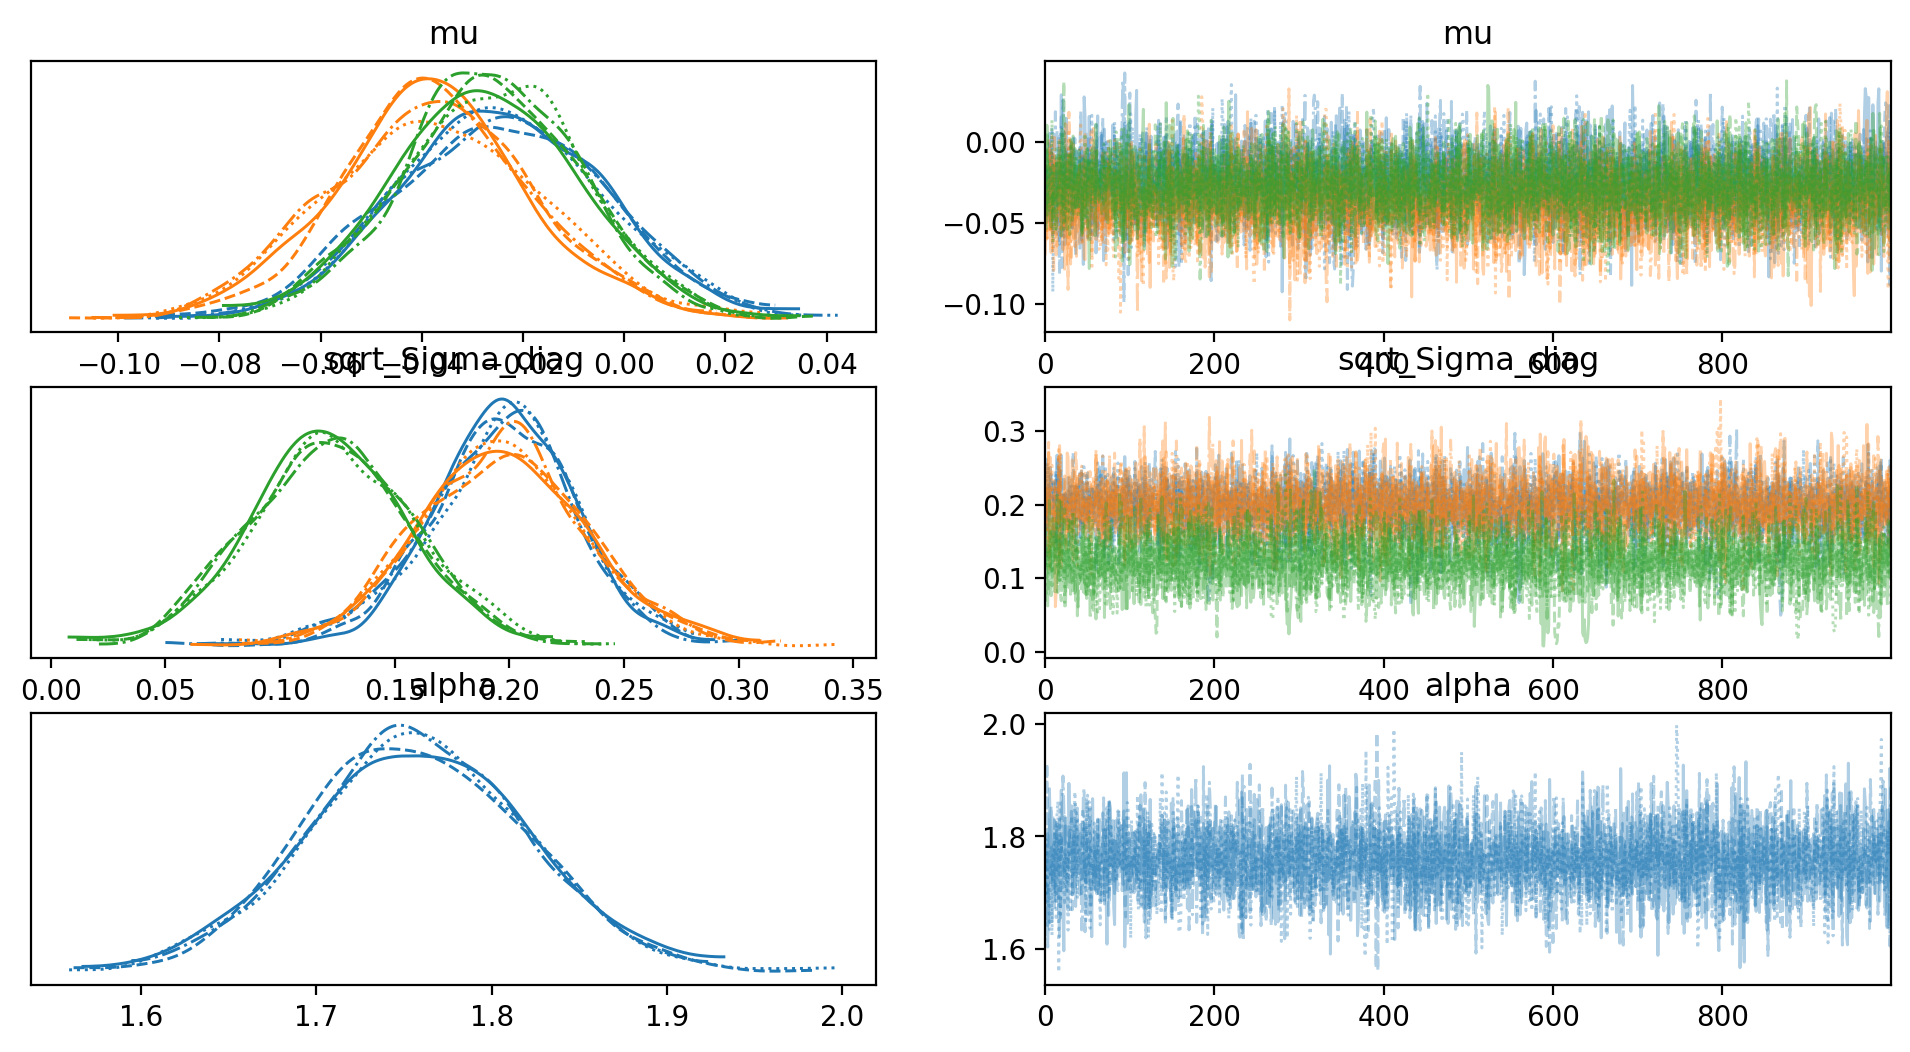

In [79]:
az.plot_trace(trace, var_names=['mu', 'sqrt_Sigma_diag', 'alpha'])

array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>],
       [<Axes: title={'center': 'sqrt_Sigma_diag\n0'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag\n1'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag\n2'}>],
       [<Axes: title={'center': 'alpha'}>, <Axes: >, <Axes: >]],
      dtype=object)

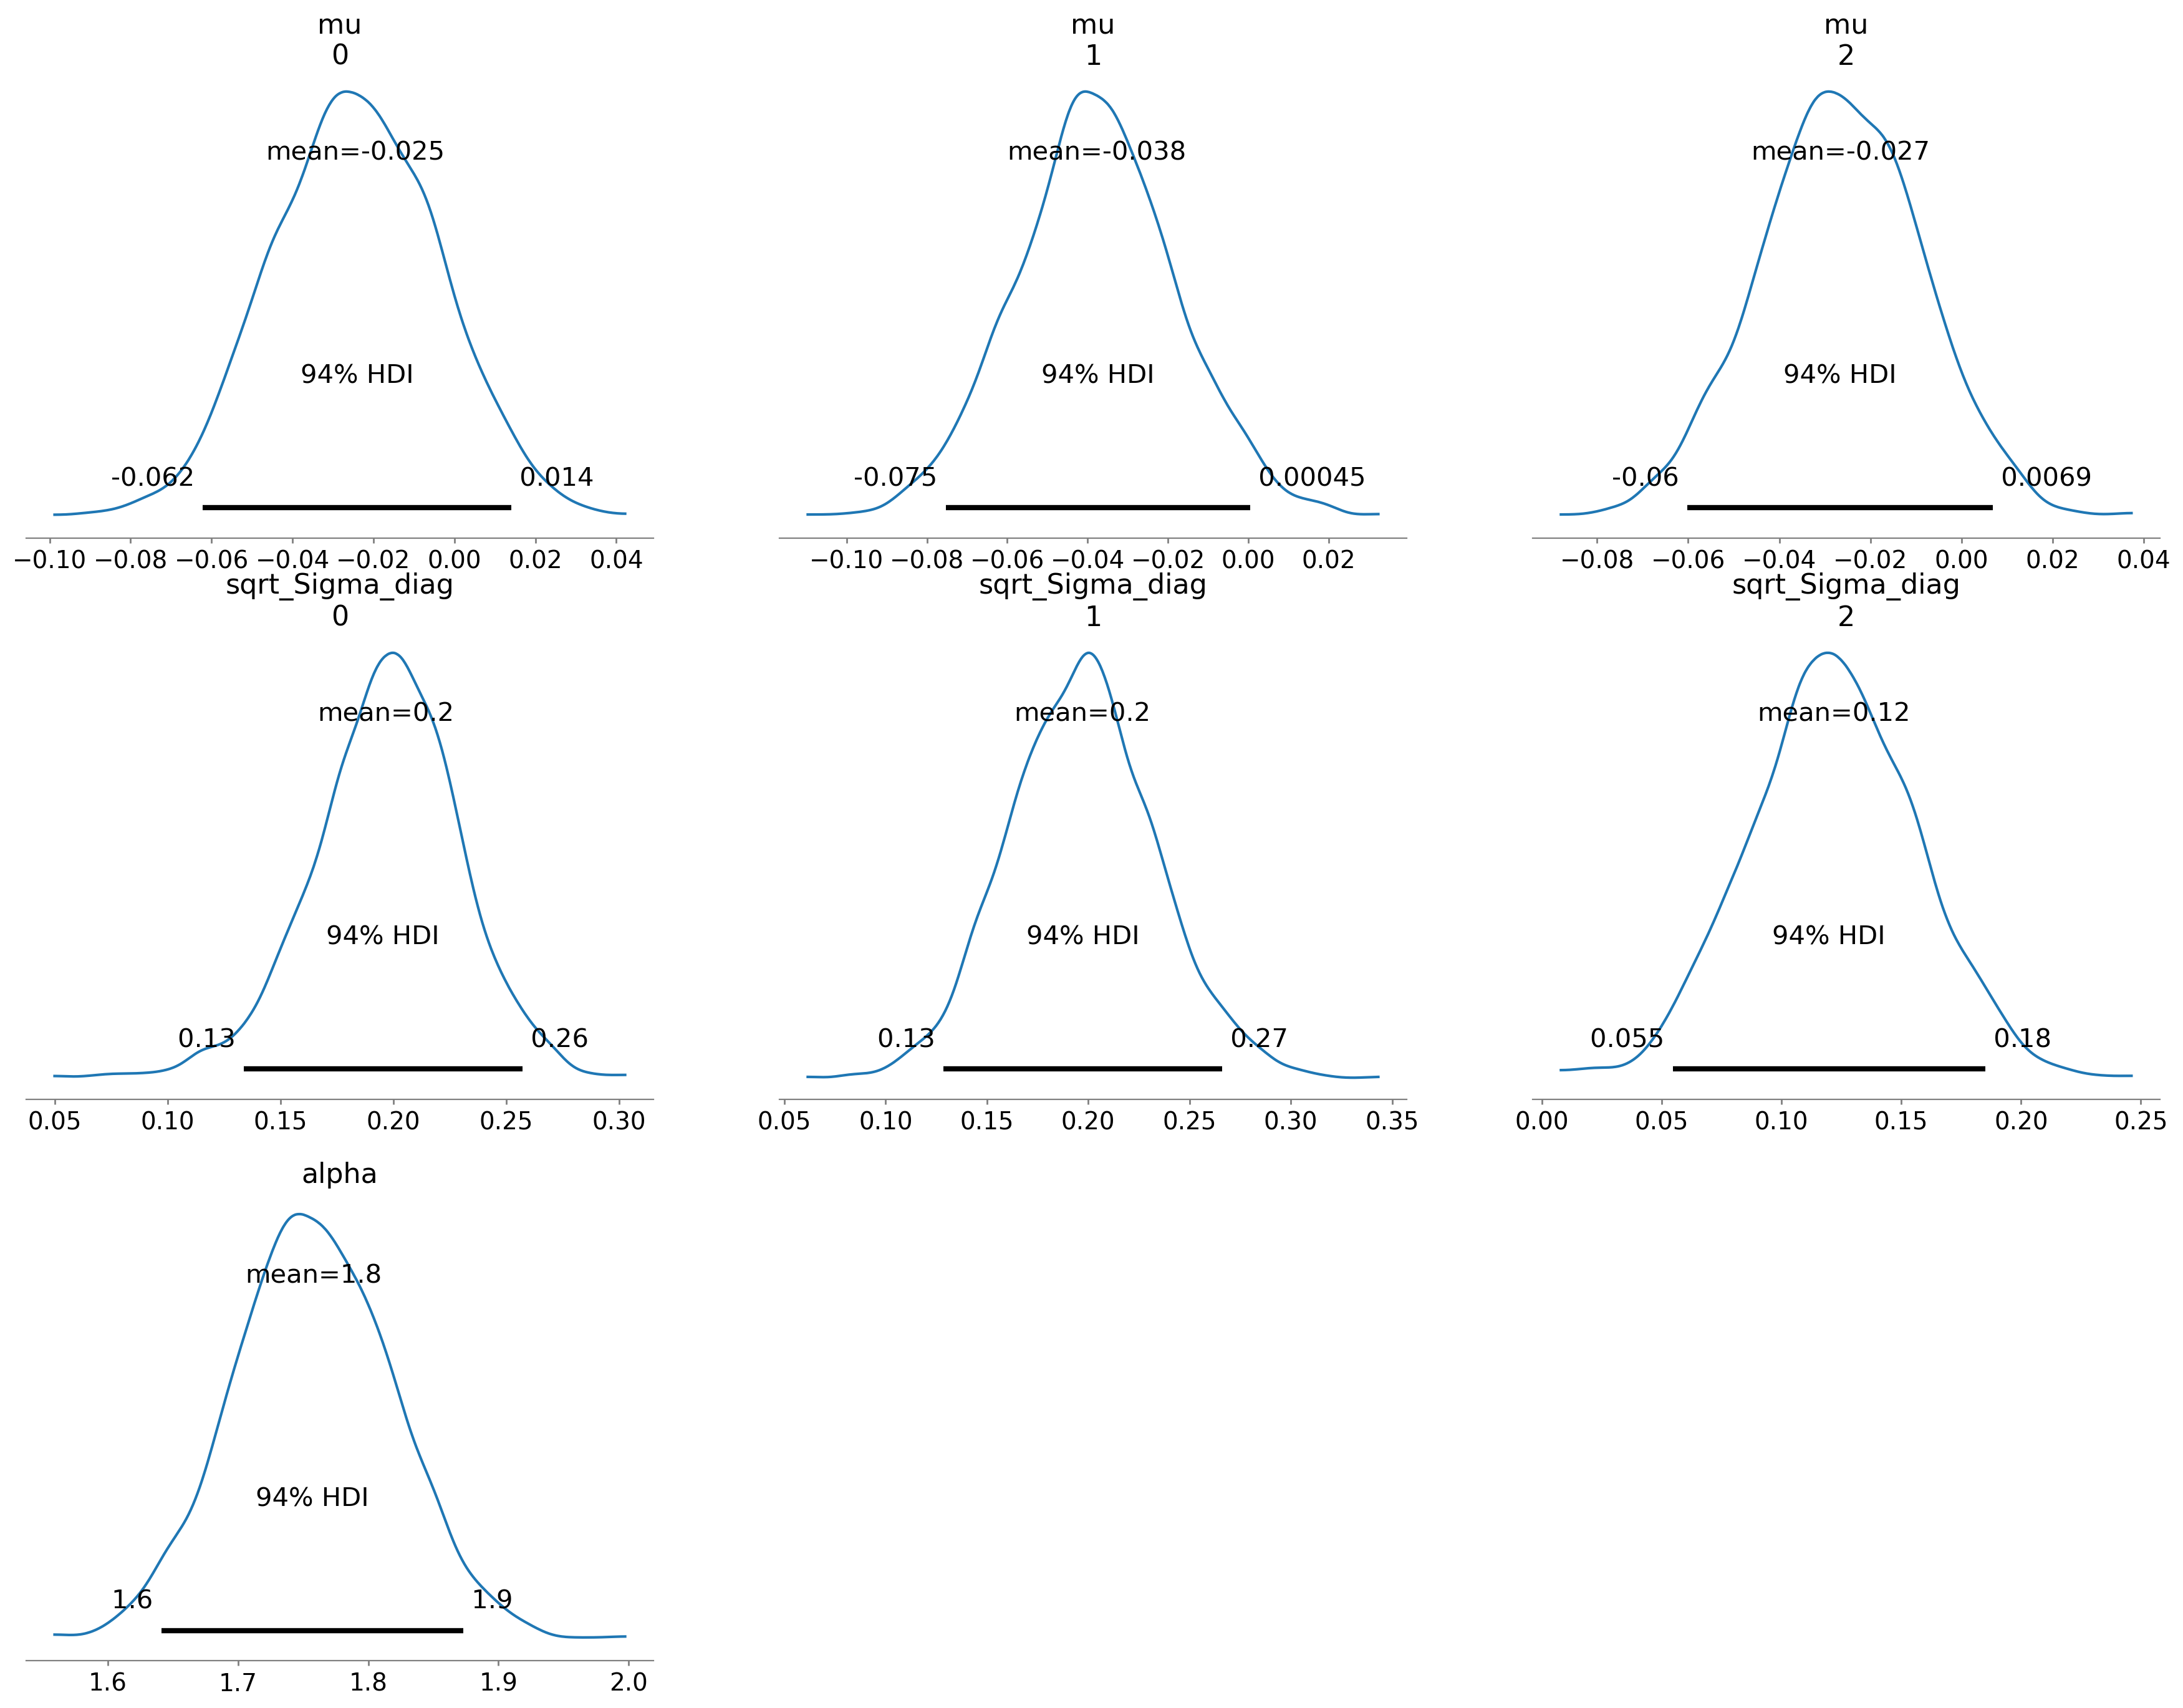

In [80]:
az.plot_posterior(trace, var_names=['mu', 'sqrt_Sigma_diag', 'alpha'])